### Segmenting Captured Tree Images

In [2]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage.io import imread, imsave
from skimage.color import rgb2gray

In [3]:
def plot_image(image, title):
    plt.imshow(image, 'gray')
    plt.title(title, size=20)
    plt.axis('off')

In [ ]:
ker_x = [[-1, 1]]
ker_y = [[-1], [1]]
im = rgb2gray(imread('images/packt_images/chess.png')[:,:,:3])
im_x = signal.convolve2d(im, ker_x, mode='same')
im_y = signal.convolve2d(im, ker_y, mode='same')
im_mag = np.sqrt(im_x**2 + im_y**2)
im_dir = np.arctan(im_y / im_x)

plt.figure(figsize=(20, 15))
plt.subplot(231), plot_image(im, 'Original')
plt.subplot(232), plot_image(im_x, 'Grad_x')
plt.subplot(233), plot_image(im_y, 'Grad_y')
plt.subplot(234), plot_image(im_mag, '||grad||')
plt.subplot(235), plot_image(im_dir, r'$\theta$')
plt.subplot(236)
plt.plot(range(im.shape[1]), im[0,:], 'b-', label=r'$f(x,y) |_{x=0}$', linewidth=5)
plt.plot(range(im.shape[1]), im_x[0,:], 'r-', label=r'$grad_x f(x,y)|_{x=0}$', linewidth=5)
plt.title(r'$grad_x (f(x,y))|_{x=0}$', size=30)
plt.legend(prop={'size': 20})
plt.show()

### Sharpening with Laplacian

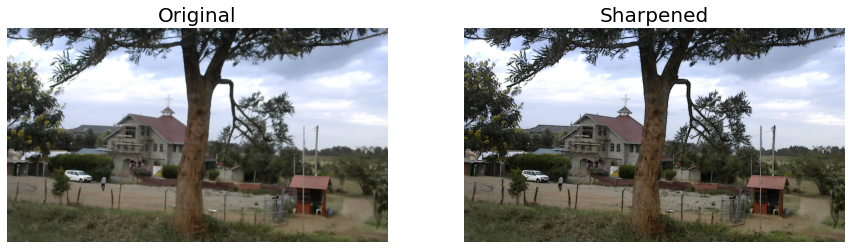

In [10]:
im = imread('trees/left_1.png')
im_r = im[:,:,0]
im_g = im[:,:,1]
im_b = im[:,:,2]


kernel1 = np.array([[0,1,0],[1,-4,1],[0,1,0]], np.dtype(np.int32))
kernel2 = np.array([[1,1,1],[1,-8,1],[1,1,1]], np.dtype(np.int32))
im_lap_r = signal.convolve2d(im_r, kernel2, mode='same')
im_lap_g = signal.convolve2d(im_g, kernel2, mode='same')
im_lap_b = signal.convolve2d(im_b, kernel2, mode='same')

im_lap_r[im_lap_r < 0] = 0
im_lap_g[im_lap_g < 0] = 0
im_lap_b[im_lap_b < 0] = 0

im_lap_r = im_lap_r.reshape((720, 1280))
im_lap_g = im_lap_g.reshape((720, 1280))
im_lap_b = im_lap_b.reshape((720, 1280))

sharpened_r = im_r - im_lap_r
sharpened_g = im_g - im_lap_g
sharpened_b = im_b - im_lap_b

sharpened_r[sharpened_r < 0] = 0
sharpened_g[sharpened_g < 0] = 0
sharpened_b[sharpened_b < 0] = 0

sharpened = np.dstack((sharpened_r, sharpened_g, sharpened_b))

plt.figure(figsize=(15, 7))
plt.subplot(121), plot_image(im, 'Original')
plt.subplot(122), plot_image(sharpened, 'Sharpened')
plt.show()

(540, 466)


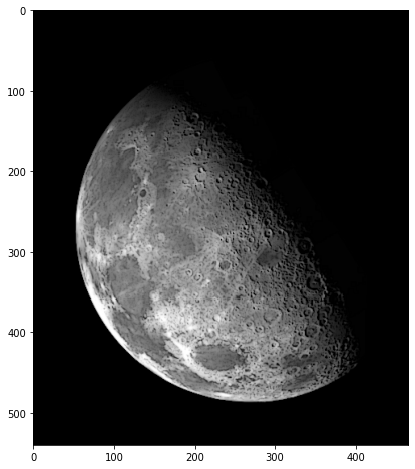

In [4]:
im = imread('DIP3E_Original_Images_CH03/Fig0338(a)(blurry_moon).tif')
print(im.shape)
kernel1 = np.array([[0,1,0],[1,-4,1],[0,1,0]])
kernel2 = np.array([[1,1,1],[1,-8,1],[1,1,1]])
im_lap = signal.convolve2d(im, kernel2, mode='same')
# im_lap = ndimage.laplace(im)
im_lap[im_lap < 0] = 0
im_lap = im_lap.reshape((540, 466))
sharpened = im - im_lap
sharpened[sharpened < 0] = 0
plt.figure(figsize=(8,8))
plt.imshow(sharpened, 'gray')
plt.show()

In [4]:
ims = glob.glob('trees2/images/*.png')
kernel1 = np.array([[0,1,0],[1,-4,1],[0,1,0]], np.dtype(np.int32))
kernel2 = np.array([[1,1,1],[1,-8,1],[1,1,1]], np.dtype(np.int32))

def sharpen(images, kernel):

    for image in images:
        img = imread(image)

        # 1. Separate the image channels for separate processing
        img_chs = [img[:,:,i] for i in range(img.shape[-1])]
        
        # 2. Apply the Laplacian Filter on each channel
        lap_chs = [signal.convolve2d(img_ch, kernel, mode='same') for img_ch in img_chs]


        # 2.1 Clip channels at 0 to remove negative pixels
        for lap_channel in lap_chs:
            lap_channel[lap_channel < 0] = 0
            lap_channel = lap_channel.reshape(img_chs[0].shape)
        
        # 3. Subtract laplacian from corresponding channel i.e. new_channel = original_channel - laplacian
        sharpened_channels = [img_ch - lap_ch for img_ch, lap_ch in zip(img_chs, lap_chs)]

        # 3.1 Clip each new channel at 0 to remove negative pixels
        for sharpened_channel in sharpened_channels:
            sharpened_channel[sharpened_channel < 0] = 0
        
        # 3.2 Assemble the 3 sharpened channels together to form RGB image and save
        sharpened = np.dstack(tuple(sharp_channel for sharp_channel in sharpened_channels))
        sharpened = np.uint8(sharpened)
        imsave('trees2/sharpened/sharpened_' + image.split('\\')[-1], sharpened, check_contrast=False)

sharpen(ims, kernel2)


### Unsharp Masking

In [4]:
ims = glob.glob('trees/*.png')

def unsharp_mask(images):

    for image in images:
        img = imread(image)

        # 1. Separate the image channels for separate processing
        img_chs = [img[:,:,i] for i in range(img.shape[-1])]
        
        # 2. Blur the original image channels
        blurred_chs = [cv2.GaussianBlur(img_ch, (31,31), 5) for img_ch in img_chs]
        
        # 3. Subtract blurred channel from original channel i.e. channel_mask = original_channel - blurred channel
        channel_masks = [img_ch - blurred_ch for img_ch, blurred_ch in zip(img_chs, blurred_chs)]
        
        # 4. Add mask to original image
        sharpened_channels = [img_ch + channel_mask for img_ch, channel_mask in zip(img_chs, channel_masks)]

        # 4.1 Assemble the 3 sharpened channels together to form RGB image and save
        sharpened = np.dstack(tuple(sharp_channel for sharp_channel in sharpened_channels))
        # sharpened = np.uint8(sharpened)
        imsave('trees/unsharp_masked/sharpened_' + image.split('\\')[-1], sharpened, check_contrast=False)

unsharp_mask(ims)


#### Masking Images

In [55]:
# images
imgL = cv2.imread('trees/sharpened/sharpened_left_1.png', 0)
imgR = cv2.imread('trees/sharpened/sharpened_right_1.png', 0)

# masks
maskL = cv2.imread('trees/matlab_masks/mask_left_1.png', 0)
maskR = cv2.imread('trees/matlab_masks/mask_right_1.png', 0)

assert(imgR.shape == maskR.shape)

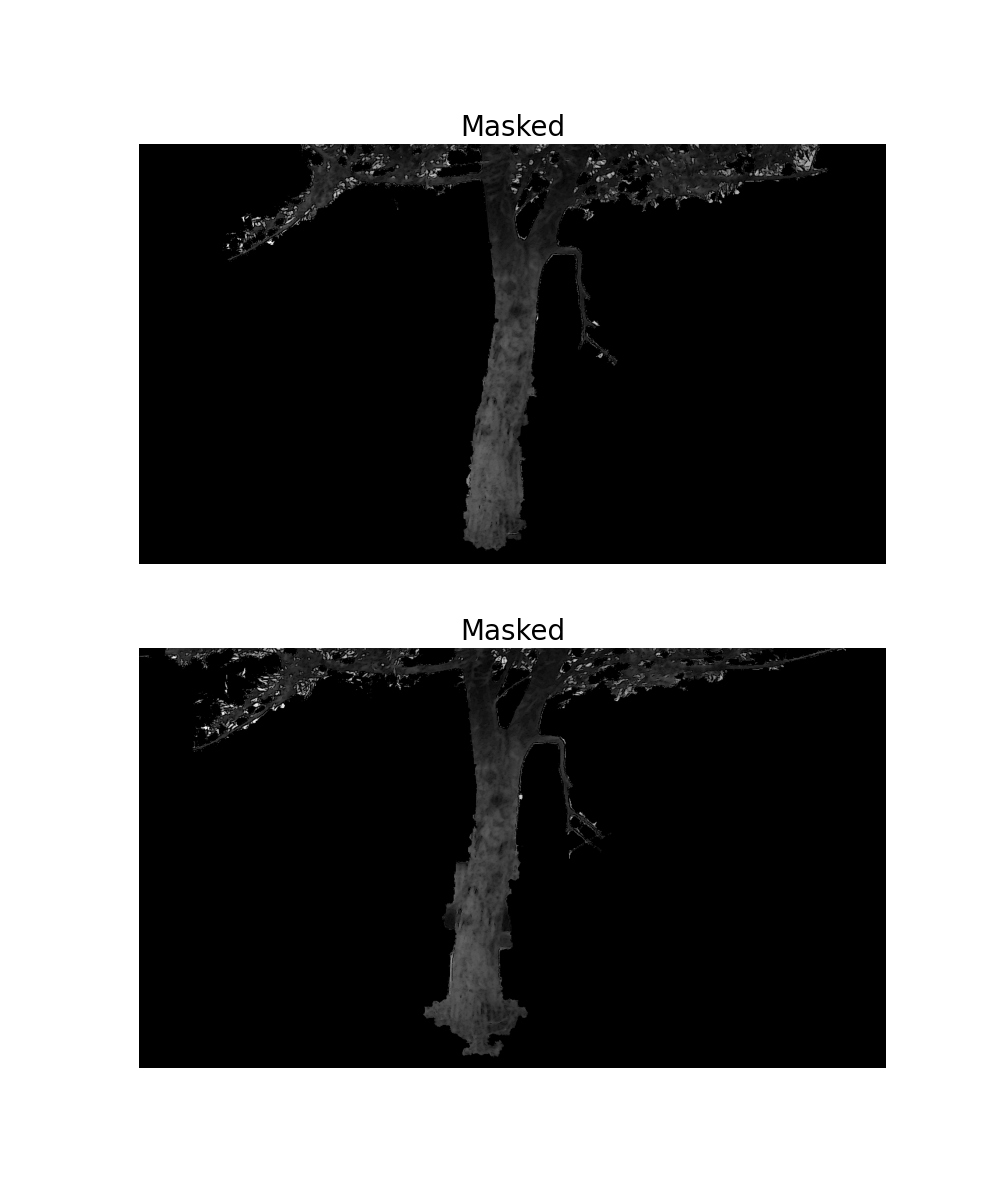

In [56]:
imgL[maskL <= 1] = 0
imgR[maskR <= 1] = 0

plt.figure(figsize=(10, 12))
plt.subplot(211)
plot_image(imgL, 'Masked')
plt.subplot(212)
plot_image(imgR, 'Masked')